# Momentum Strategies

Momentum Strategies in credit, a review of different trend strategies applied to credit indices

In [1]:
import os
import sys
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from   matplotlib.ticker import FuncFormatter

In [2]:
sys.path.append(r"C:\Users\Diego\Desktop\app_prod\research\CreditMomentum\root\src")
from MomentumCDS import MomentumCreditSignals

## Regression Line Signals

In [3]:
def get_beta_signal() -> pd.DataFrame: 
    
    df_tmp = (MomentumCreditSignals().get_regression_signals().rename(
        columns = {"px_rtn": "log_rtn"}))

    df_rtn = (df_tmp[
        ["date", "security", "px"]].
        drop_duplicates().
        pivot(index = "date", columns = "security", values = "px").
        pct_change().
        reset_index().
        melt(id_vars = "date").
        rename(columns = {"value": "px_rtn"}).
        dropna())

    df_out = (df_tmp.merge(
        right = df_rtn, how = "inner", on = ["date", "security"]))
    
    return df_out

df_beta = get_beta_signal()

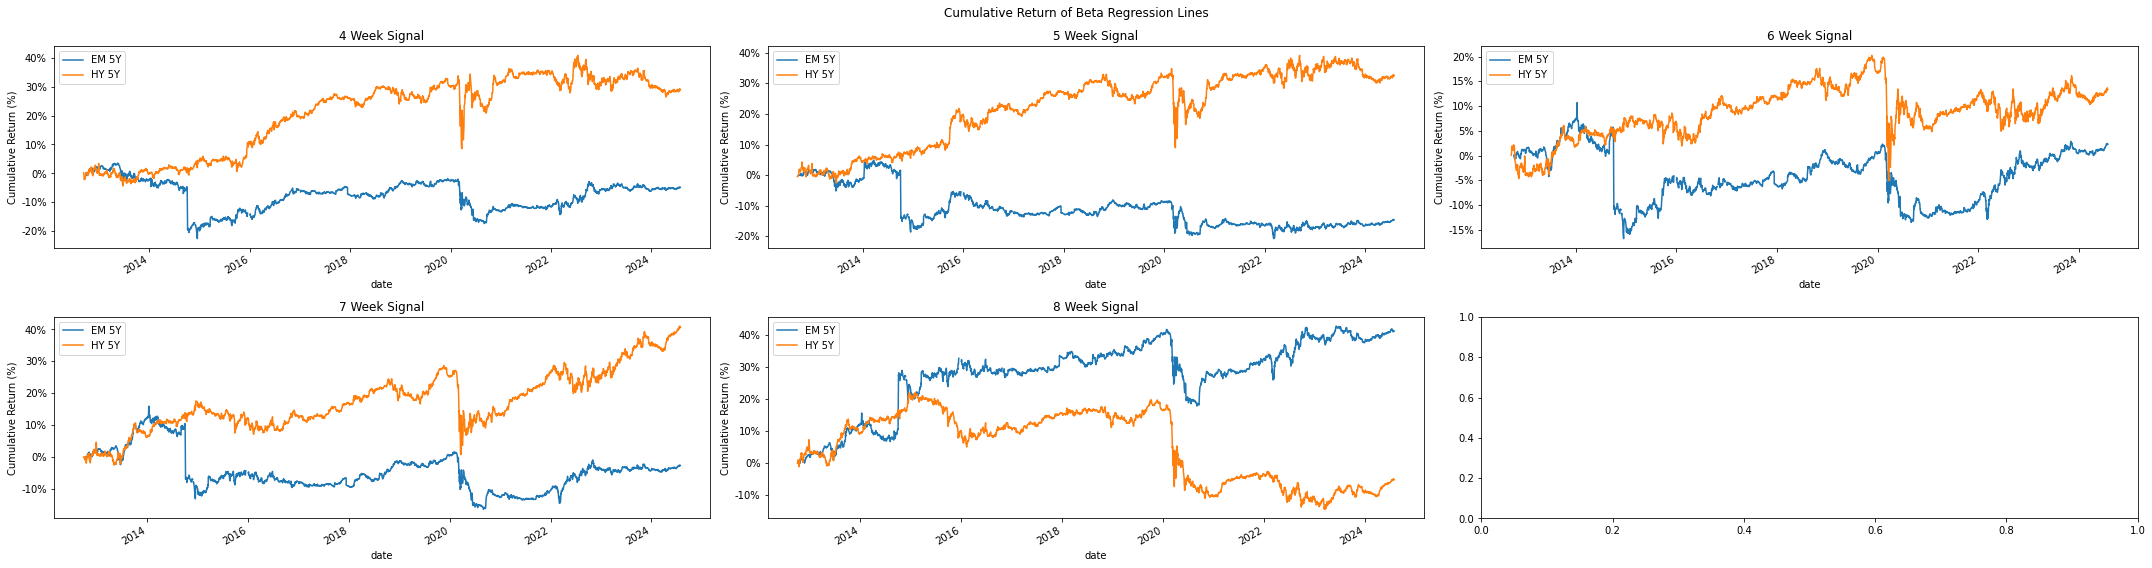

In [4]:
def plot_beta_rtn(df_beta: pd.DataFrame) -> plt.Figure: 
    
    fig, axes = plt.subplots(ncols = 3, nrows = 2, figsize = (30,8))

    for window, ax in zip(df_beta.window.drop_duplicates(), axes.flatten()):

        (df_beta.query(
            "window == @window").
            assign(signal_rtn = lambda x: -1 * np.sign(x.lag_beta) * x.px_rtn)
            [["date", "security", "signal_rtn"]].
            assign(security = lambda x: x.security.str.split("CDX").str[-1].str.strip().str.replace(" CDSI", "")).
            rename(columns = {"security": ""}).
            pivot(index = "date", columns = "", values = "signal_rtn").
            apply(lambda x: np.cumprod(1 + x) - 1).
            plot(
                ax     = ax,
                title  = window.split("week")[0] + " Week Signal",
                ylabel = "Cumulative Return (%)"))

        ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: f"{y:.0%}"))

    fig.suptitle("Cumulative Return of Beta Regression Lines")
    plt.tight_layout()
    
plot_beta_rtn(df_beta)

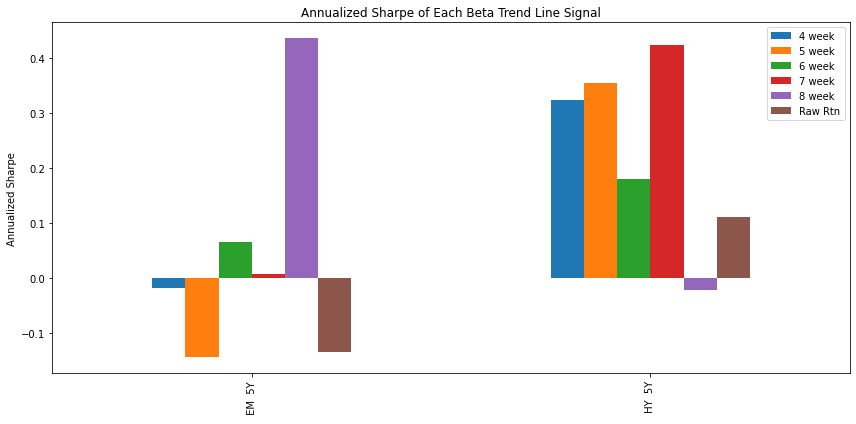

In [5]:
def plot_sharpe(df_beta: pd.DataFrame) -> plt.Figure: 
    
    df_tmp = (df_beta.assign(
        signal_rtn = lambda x: -1 * np.sign(x.lag_beta) * x.px_rtn,
        window   = lambda x: x.window.str.replace("w", " w"))
        [["window", "security", "signal_rtn"]].
        groupby(["window", "security"]).
        agg(["mean", "std"])
        ["signal_rtn"].
        rename(columns = {
            "mean": "mean_rtn",
            "std" : "std_rtn"}).
        assign(sharpe = lambda x: x.mean_rtn / x.std_rtn * np.sqrt(252)).
        drop(columns = ["mean_rtn", "std_rtn"]).
        reset_index().
        pivot(index = "security", columns = "window", values = "sharpe"))

    df_raw = (df_beta[
        ["date", "security", "px_rtn"]].
        drop_duplicates().
        drop(columns = ["date"]).
        groupby("security").
        agg(["mean", "std"])
        ["px_rtn"].
        rename(columns = {
            "mean": "mean_rtn",
            "std" : "std_rtn"}).
        assign(sharpe = lambda x: x.mean_rtn / x.std_rtn * np.sqrt(252))
        [["sharpe"]].
        rename(columns = {"sharpe": "Raw Rtn"}))

    df_sharpe = (df_tmp.merge(
        right = df_raw, how = "inner", on = ["security"]).
        reset_index().
        assign(security = lambda x: x.security.str.replace("CDX", "").str.replace("CDSI", "")).
        set_index("security"))

    df_sharpe.plot(
        kind = "bar", 
        xlabel = "", 
        ylabel = "Annualized Sharpe",
        figsize = (12,6),
        title = "Annualized Sharpe of Each Beta Trend Line Signal")
    
    plt.tight_layout()
    
plot_sharpe(df_beta)

## Regression Z-Score

In [6]:
def get_zscore() -> pd.DataFrame: 
    
    df_tmp = (MomentumCreditSignals().generate_regression_zscore().rename(
        columns = {"px_rtn": "log_rtn"}))

    df_out = (df_tmp[
        ["date", "security", "px"]].
        drop_duplicates().
        pivot(index = "date", columns = "security", values = "px").
        pct_change().
        reset_index().
        melt(id_vars = "date").
        rename(columns = {"value": "px_rtn"}).
        merge(right = df_tmp, how = "inner", on = ["date", "security"]).
        assign(signal_rtn = lambda x: - np.sign(x.lag_zscore) * x.px_rtn).
        dropna())
    
    return df_out

df_zscore = get_zscore()

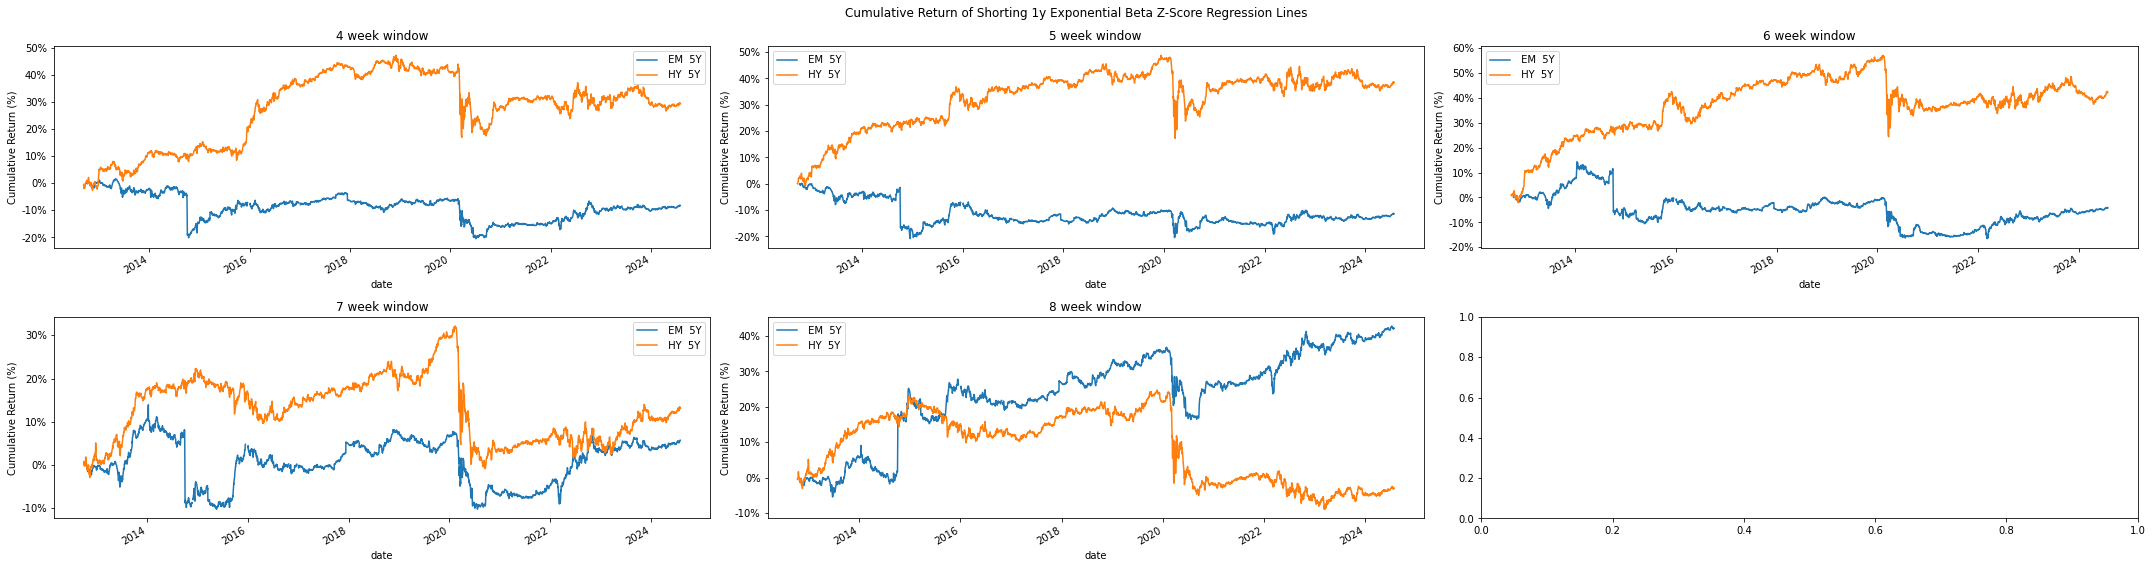

In [7]:
def plot_zscore(df_zscore: pd.DataFrame) -> plt.Figure: 
    
    windows   = df_zscore.window.drop_duplicates().to_list()
    fig, axes = plt.subplots(ncols = 3, nrows = 2, figsize = (30,8))

    for window, ax in zip(windows, axes.flatten()):

        (df_zscore.query(
            "window == @window")
            [["date", "security", "signal_rtn"]].
            assign(security = lambda x: x.security.str.replace("CDX", "").str.replace("CDSI", "")).
            rename(columns = {"security": ""}).
            pivot(index = "date", columns = "", values = "signal_rtn").
            apply(lambda x: np.cumprod(1 + x) - 1).
            plot(
                ax     = ax,
                title  = window.replace("w", " w") + " window",
                ylabel = "Cumulative Return (%)"))

        ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: f"{y:.0%}"))

    fig.suptitle("Cumulative Return of Shorting 1y Exponential Beta Z-Score Regression Lines")
    plt.tight_layout()
    
plot_zscore(df_zscore)

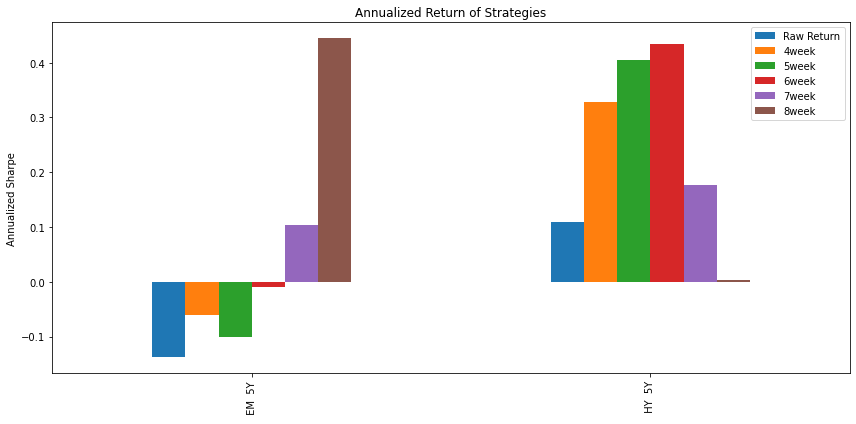

In [8]:
def plot_zscore_sharpe(df_zscore: pd.DataFrame) -> pd.DataFrame: 
    
    df_sharpe = (df_zscore[
        ["security", "window", "signal_rtn"]].
        groupby(["security", "window"]).
        agg(["mean", "std"])
        ["signal_rtn"].
        rename(columns = {
            "mean": "mean_rtn",
            "std" : "std_rtn"}).
        assign(sharpe = lambda x: x.mean_rtn / x.std_rtn * np.sqrt(252)).
        drop(columns = ["mean_rtn", "std_rtn"]).
        reset_index().
        pivot(index = "security", columns = "window", values = "sharpe"))

    df_all = (df_zscore[
        ["date", "security", "px_rtn"]].
        drop_duplicates().
        drop(columns = ["date"]).
        groupby("security").
        agg("px_rtn").
        agg(["mean", "std"]).
        rename(columns = {
            "mean": "mean_rtn",
            "std" : "std_rtn"}).
        assign(sharpe = lambda x: x.mean_rtn / x.std_rtn * np.sqrt(252)).
        drop(columns = ["mean_rtn", "std_rtn"]).
        rename(columns = {"sharpe": "Raw Return"}).
        merge(right = df_sharpe, how = "inner", on = ["security"]).
        reset_index().
        assign(security = lambda x: x.security.str.replace("CDX", "").str.replace("CDSI", "")).
        set_index("security"))

    (df_all.plot(
        kind    = "bar",
        figsize = (12,6),
        ylabel  = "Annualized Sharpe",
        xlabel  = "",
        title   = "Annualized Return of Strategies"))
    
    plt.tight_layout()
    
plot_zscore_sharpe(df_zscore)